# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import sklearn as sk
import itertools as it

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]
print X_dataset.shape

(16474, 586990)


Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test_submition.csv" # WRN: [test.csv uids] != [test_submition.csv uids]
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex]) # WRN: make sure TRAINING_SET and EXAMPLE_SET uids do not overlap

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train[df_users_train['uid'].isin(users)]['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7186x586990) feature matrix, 7186 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

X axis from 1 to 6877.2
Y axis from 0.5 to 309417.9


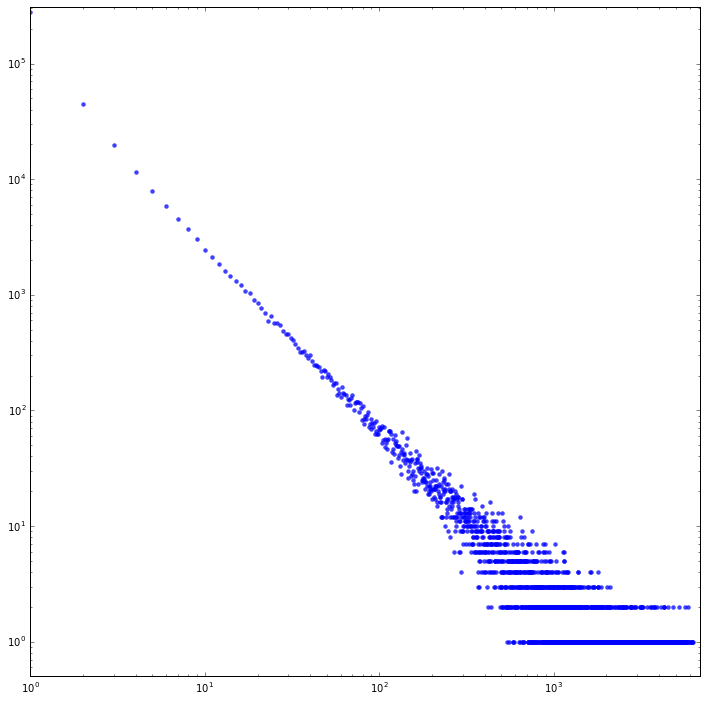

In [6]:
def draw_log_hist(X):
    features_counts = np.array((X > 0).sum(axis=0)).ravel() # frequency of each feature
    tmp_x, tmp_y = np.unique(features_counts, return_counts=True) # frequency and amount
    plt.figure(figsize=(12, 12))
    plt.xscale('log') # transform to log axis
    plt.yscale('log')
    plt.xlim(1, tmp_x.max() * 1.1)
    plt.ylim(0.5, tmp_y.max() * 1.1) # 0.5 for better visibility
    print "X axis from", 1, "to", tmp_x.max() * 1.1
    print "Y axis from", 0.5, "to", tmp_y.max() * 1.1
    plt.scatter(tmp_x, tmp_y, c = 'b', linewidths = 0, alpha = 0.75)
    plt.show()
    
    return features_counts.astype(np.int)

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [7]:
X1 = X.tocsc()[:, features_counts > 100].toarray()
print X1.shape

(7186L, 10259L)


Вариант задания генерируется на основании вашего ника в техносфере.

In [8]:
USER_NAME = "a.bogovskij"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [9]:
import sklearn.linear_model as sklm

def sigm_func(x):
    return 1.0 / (1.0 + np.exp(-x))

class LogisticRegression():
    def __init__(self, C = 1, threshold = 0.5, max_it = 30000, eps = 0.001, step = 0.5):
        self.C = C
        self.threshold = threshold
        self.max_it = max_it
        self.eps = eps
        self.step = step # not the real step, we use it for  eta = it_num ** (-step)
    
    def get_params(self, deep=True):
        return {'C': self.C, 'threshold': self.threshold, 'max_it': self.max_it, 'eps': self.eps, 'step': self.step}
    
    def set_params(self, params):
        self.C = params['C']
        self.threshold = params['threshold']
        self.max_it = params['max_it']
        self.eps = params['eps']
        self.step = params['step']
            
    ####################################       
    def grad_desc(self, w0, X, Y, C):
        grad = np.dot(X,(sigm_func(np.dot(X.T, w0)) - Y))/ X.shape[0]
        grad += float(C) * np.abs(w0) / X.shape[0]
        return grad
        
    def fit(self, X, Y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        it_num = 1
        if Y.ndim == 1:
            Y = Y[:,np.newaxis]
        self.w0 = np.zeros((X.shape[1], 1)) # initial approximation
        while True:
            eta = it_num ** (-self.step)
            rand_num = pr.randint(0,X.shape[0]-1)
            X_new = X[rand_num]
            X_new = X_new[:,np.newaxis]
            grad = self.grad_desc(self.w0, X_new, Y[rand_num], self.C)
            self.w0 -= eta * grad
            it_num += 1
            if it_num > self.max_it or np.all(np.abs(eta * grad) < self.eps):
                break
        #print "Iterations:",it_num
        
        return self
    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigm_func(np.dot(X, self.w0))
    
    def predict(self, X):
        p = self.predict_proba(X)
        return np.greater(p, self.threshold)

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [11]:
def auroc(y_prob, y_true):
    fpr, tpr, thresholds = sm.roc_curve(y_true, y_prob)
    return tpr, fpr, np.trapz(tpr, fpr)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [12]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000] # reg param
T = [0.15, 0.175, 0.20, 0, 0.225, 0.25] #[0.25, 0.5, 0.75] # 1.0 class threshold

In [13]:
def select_params(X, Y):
    best_cvp = 0
    best_i = 0
    best_j = 0
    for i, c in enumerate(C):
        for j, t in enumerate(T):
            cvp = np.mean(cv.cross_val_score(LogisticRegression(C=c, threshold=t), X, Y, cv=10, scoring='accuracy'))
            if cvp > best_cvp:
                best_cvp = cvp
                best_i = i
                best_j = j
            print cvp,
        print ''
    return best_i, best_j

C_idx, T_idx = select_params(X1, Y)
print C_idx, T_idx

0.779436194653 0.778182712759 0.779436194653 0.779436194653 0.779436194653 0.779436194653 
0.774846486725 0.77707179966 0.779575470419 0.779436194653 0.779436194653 0.779436194653 
0.777765466584 0.776932717601 0.778879091589 0.779436194653 0.778600540057 0.779436194653 
0.778600540057 0.779436194653 0.777628127894 0.779436194653 0.776236726187 0.779297112594 
0.776652422701 0.779018367355 0.779436194653 0.779436194653 0.779714552477 0.775398165976 
0.779436194653 0.774985375076 0.779436194653 0.779436194653 0.779436194653 0.779157643121 
0.779436194653 0.779436194653 0.779297112594 0.779436194653 0.778045374069 0.779436194653 
0.636613642439 0.554039965752 0.719686891032 0.581673711166 0.719686891032 0.522904180597 
4 4


In [14]:
def GetChunks(Xs, chunks_cnt):
    chunks_size = len(Y) / chunks_cnt
    return [[X[i : i + chunks_size] for i in xrange(0, len(X), chunks_size)] for X in Xs]

def NormalizedChunks(X, Y, neg_chunks_cnt = 2):
    ix_pos, ix_neg = (Y == 1.0), (Y == 0.0)
    cnt_pos, cnt_neg = ix_pos.sum(), ix_neg.sum()
    pos_Xs, pos_Ys = GetChunks([X[ix_pos], Y[ix_pos]], int(cnt_pos / (cnt_neg / float(neg_chunks_cnt))))
    neg_Xs, neg_Ys = GetChunks([X[ix_neg], Y[ix_neg]], neg_chunks_cnt)
    return pos_Xs, pos_Ys, neg_Xs, neg_Ys

def GetSplit(pos_Xs, pos_Ys, neg_Xs, neg_Ys, i, j):
    get_all_except = lambda A, eidx: [A[k] for k in xrange(len(A)) if k != eidx] 
    
    to_test_X = get_all_except(pos_Xs, i)
    to_test_X.extend(get_all_except(neg_Xs, i)) 
    
    to_test_Y = get_all_except(pos_Ys, i)
    to_test_Y.extend(get_all_except(neg_Ys, i))

    test_X, test_Y = np.concatenate(to_test_X), np.concatenate(to_test_Y)
    train_X, train_Y = np.concatenate([pos_Xs[i], neg_Xs[j]]), np.concatenate([pos_Ys[i], neg_Ys[j]])    
    return train_X, train_Y, test_X, test_Y

def NormalizedSelectParams(X, Y):
    pos_Xs, pos_Ys, neg_Xs, neg_Ys = NormalizedChunks(X, Y)
    lr = LogisticRegression()
    acc = np.zeros(shape=(len(pos_Xs), len(neg_Xs), len(C), len(T)), dtype=float)
    for i in xrange(len(pos_Xs)):
        for j in xrange(len(neg_Xs)):
            print '\r', i, j,
            train_X, train_Y, test_X, test_Y = GetSplit(pos_Xs, pos_Ys, neg_Xs, neg_Ys, i, j)
            for idx_c, c in enumerate(C):
                lr.C = c
                lr.fit(train_X, train_Y)
                for idx_t, t in enumerate(T):
                    lr.threshold = t
                    acc[i, j, idx_c, idx_t] = sm.accuracy_score(test_Y, lr.predict(test_X))
                print '.',
    acc = np.mean(acc, axis=(0,1))
    print '\r{}'.format(acc)
    return np.unravel_index(np.argmax(acc), acc.shape)
                   
n_C_idx, n_T_idx = NormalizedSelectParams(X1, Y)
print n_C_idx, n_T_idx

[[ 0.78624205  0.78436672  0.78170344  0.78912342  0.77540492  0.76357381]
 [ 0.78893402  0.78872609  0.78803539  0.78912342  0.78616271  0.78274447]
 [ 0.78868626  0.78857697  0.78822204  0.78912342  0.78784837  0.78708334]
 [ 0.78859996  0.78857738  0.78809685  0.78912342  0.78713155  0.78625636]
 [ 0.78784837  0.78759336  0.78736541  0.78912342  0.78690119  0.78603625]
 [ 0.77604906  0.7749782   0.77303377  0.78912342  0.76851324  0.7625647 ]
 [ 0.77650496  0.77093005  0.76258469  0.78912342  0.75203391  0.74112895]
 [ 0.54642861  0.54642861  0.54642861  0.54642861  0.54642861  0.54642861]]
0 3


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.501389


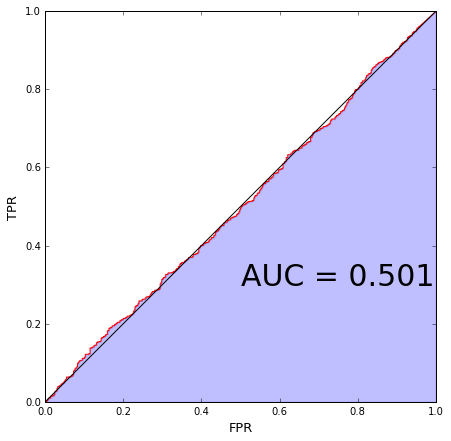

In [15]:
def classify(X, Y, test_size, c, t):
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size = test_size, random_state=42)
    logreg = LogisticRegression(c, t, eps = 0.00001)
    logreg.fit(X_train, Y_train)
    Y_prob = logreg.predict_proba(X_test)
    tpr, fpr, roc_auc = auroc(Y_prob, Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[C_idx], T[T_idx])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot(111)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.plot(fpr, tpr, color='red')
    plt.plot([0, 1], [0, 1], color='black') # diagonal
    pl.fill_between(fpr, tpr, alpha=0.25, color='blue')
    pl.text(0.5, 0.3, "AUC = %0.3f" % roc_auc, fontsize=30)
    plt.xlabel("FPR", fontsize=13)
    plt.ylabel("TPR", fontsize=13)
    plt.show()
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [16]:
ex_users = df_users_ex['uid'].values
eix = np.in1d(users, ex_users).reshape(users.shape)
ex_X = X_dataset[np.where(eix)]
ex_X1 = ex_X.tocsc()[:, features_counts > 100].toarray()
print "Resulting test set: (%dx%d) feature matrix" % (ex_X1.shape[0], ex_X1.shape[1])

Resulting test set: (4527x10259) feature matrix


In [17]:
lr = LogisticRegression(C[C_idx], T[T_idx], eps = 0.00001)
lr.fit(X1, Y)
Y_pred = lr.predict_proba(ex_X1)

In [18]:
fpredict = open("predict.csv", "wt")
fpredict.write("uid,cls\n")
count = 0
for i in xrange(len(eix)):
    if eix[i]:
        fpredict.write(str(users[i]) + "," + str(float(Y_pred[count])) + "\n")
        count += 1
print "Total", count, "written."
print "Now add users without any info"
count = 0
for i in df_users_ex['uid']:
    if i not in users:
        fpredict.write(str(i) + "," + str(pr.random()) + "\n")
        count += 1
print "Total", count, "unpredicted users written."
fpredict.close()

Total 4527 written.
Now add users without any info
Total 221 unpredicted users written.
